# Analyzing integration timescales with spectral coherence

In [15]:
%matplotlib inline
import cortex
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import h5py
import os
import nibabel as nib
from collections import defaultdict
import statsmodels.api as sm

#### Load functional ROI data

In [2]:
subject, xfm = 'S1', 'fullhead'
dir = '/Users/jiamingxu/Desktop/Language_straightenting/data/vision_fixation'

In [11]:
f_data_file = 'vision_fixation_resp.hf5'
f_data_path = os.path.join(dir, f_data_file)

with h5py.File(f_data_path, 'r') as file:
    file_name = list(file.keys())[0]
    response_trials = np.array(file[file_name])
    print(response_trials.shape) 

mask = cortex.db.get_mask(subject,xfm)
np.sum(mask == True)

(10, 90, 80615)


80615

#### Load anatomical ROI data

In [4]:
lab_l,ctab_l,names_l = nib.freesurfer.read_annot(f'{dir}/{subject}/label/lh.aparc.annot')
print(lab_l.shape, ctab_l.shape, len(names_l))

lab_r,ctab_r,names_r = nib.freesurfer.read_annot(f'{dir}/{subject}/label/rh.aparc.annot')
print(lab_r.shape, ctab_r.shape, len(names_r))

assert np.all(names_l == names_r)
names = [n.decode("utf-8") for n in names_l]

(152893,) (36, 5) 36
(151487,) (36, 5) 36


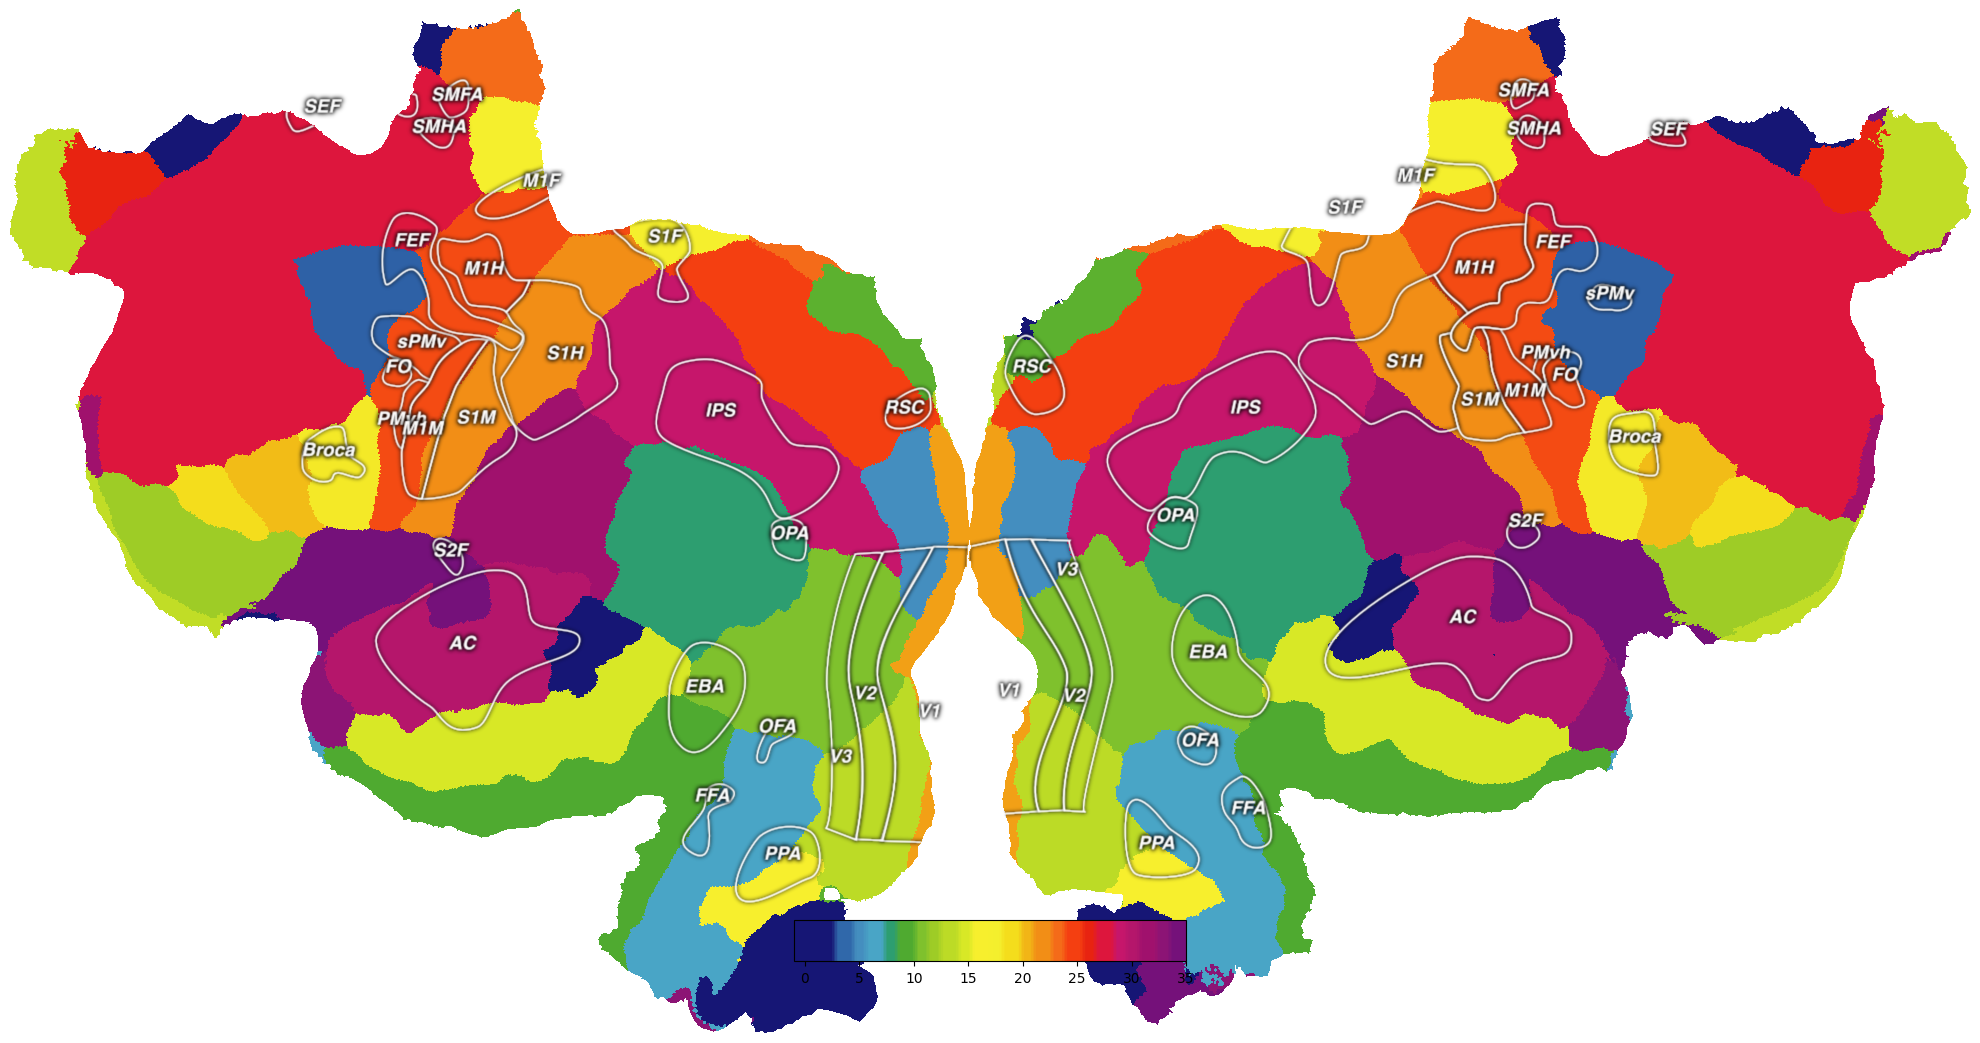

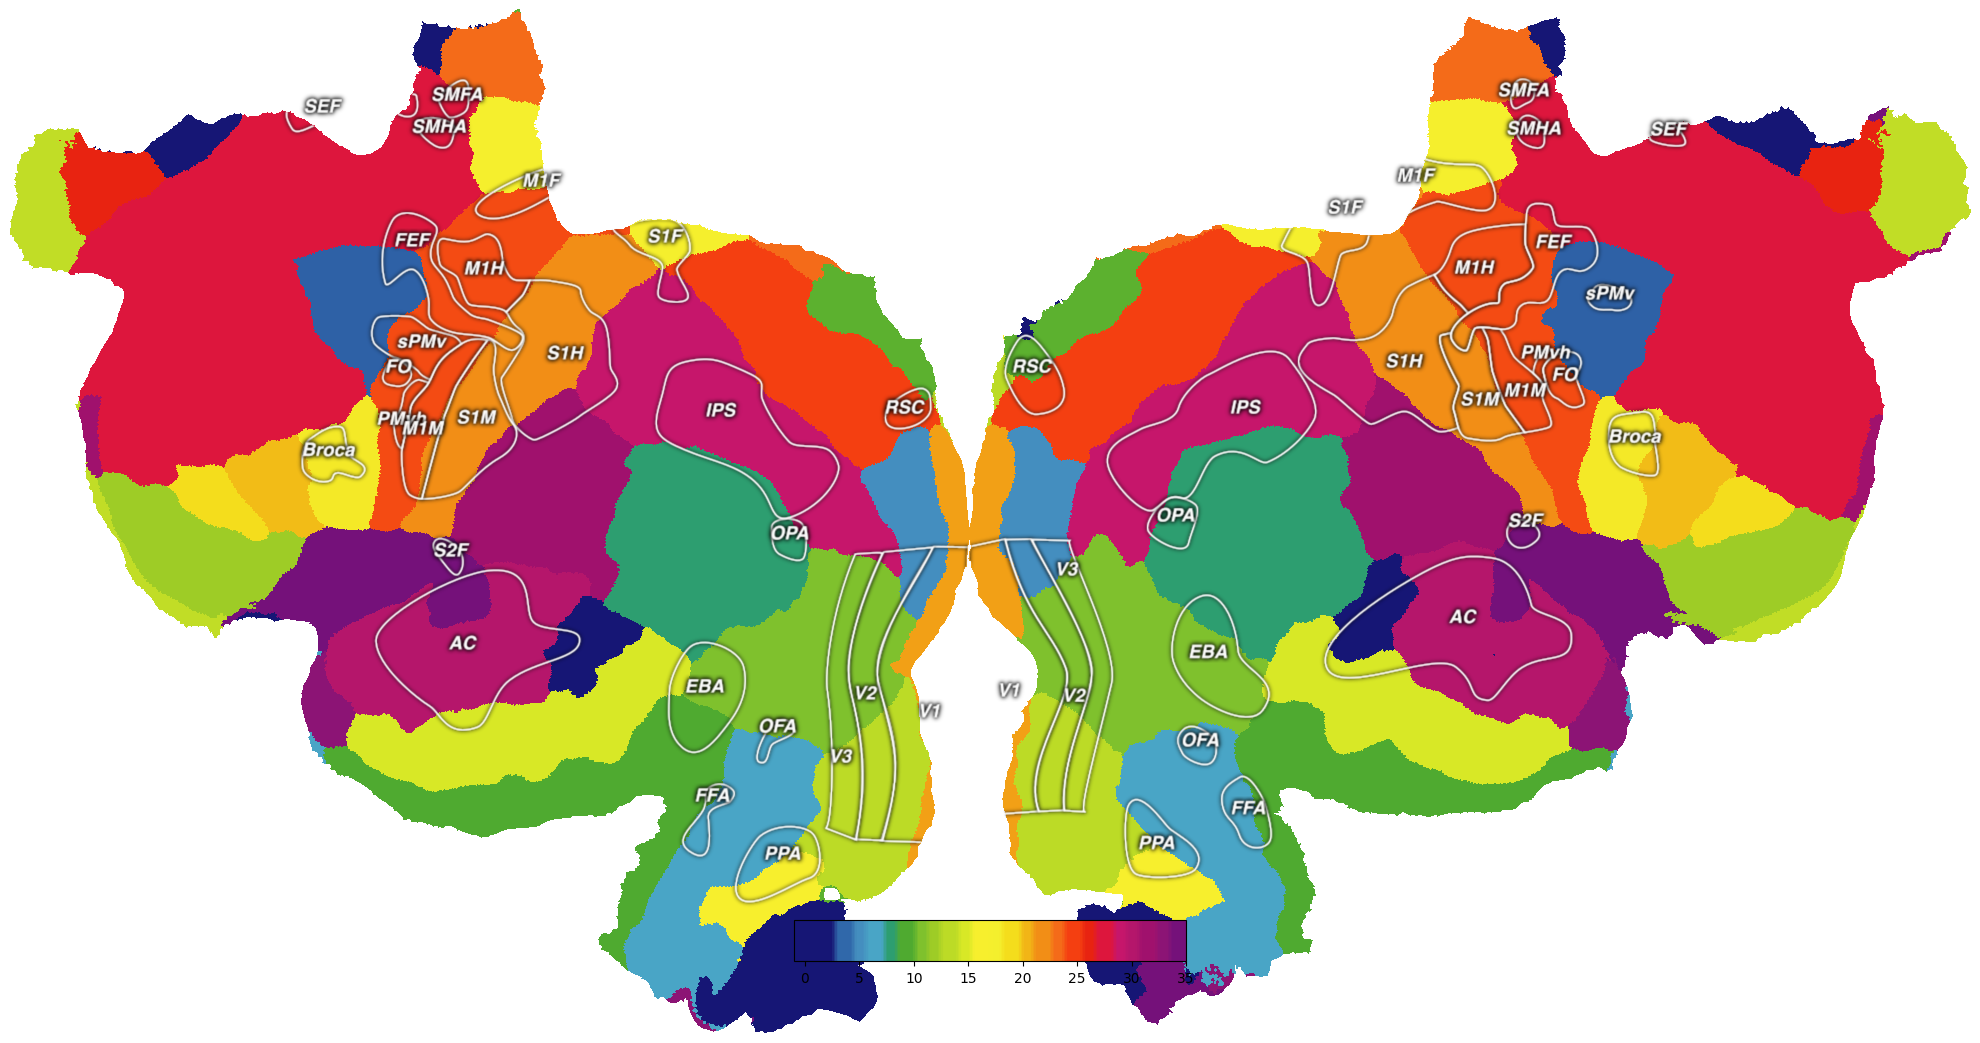

In [8]:
cortex.quickshow(cortex.Vertex(np.hstack([lab_l, lab_r]), subject, cmap='J4'))

#### Get ROI voxels (functional & anatomical) 

In [5]:
# choose functional rois
f_rois = ['V1','V2','V3','IPS', 'EBA', 'FEF']  
f_roi_voxs = {} 
# get 3d mask of voxels that belong to roi
roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)
for roi in f_rois:
    roi_mask = roi_masks[roi]
    f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

Cutting 6 overlapping voxels (should be < ~50)


In [6]:
# choose anatomical rois
a_rois = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
# combine PFC voxels
rois_to_combine = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
# get mask
mask = cortex.db.get_mask(subject, xfm)
Mapper = cortex.get_mapper(subject, xfm, 'line_nearest')
Map_l = Mapper.masks[0][:, mask.ravel()]
Map_r = Mapper.masks[1][:, mask.ravel()]

a_roi_voxs = {}

for lm in range(len(a_rois)):
    vert_l = set((lab_l==lm).nonzero()[0].tolist())
    vert_r = set((lab_r==lm).nonzero()[0].tolist())
    vox_l = Map_l[list(vert_l), :].nonzero()[1]
    vox_r = Map_r[list(vert_r), :].nonzero()[1]
    a_roi_voxs[a_rois[lm]] = np.sort(list(set(map(int, np.hstack([vox_r, vox_l])))))

pfc_voxs = []
for roi in rois_to_combine:
    pfc_voxs.extend(a_roi_voxs[roi])
    
pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

for roi in rois_to_combine: # remove old keys
    del a_roi_voxs[roi]

In [7]:
# combine functional and anatomical
roi_voxs = {**f_roi_voxs, **a_roi_voxs}  

# print number of voxels in each ROI
len(roi_voxs)
for key, value in roi_voxs.items():
    print(f"{key}: {len(value)} items")

V1: 627 items
V2: 565 items
V3: 477 items
IPS: 1242 items
EBA: 528 items
FEF: 444 items
prefrontal: 3649 items


## 1. Estimate PSD for each frequency bin

Re-normalize after averaging across repeats for each voxel

In [12]:
# zero all the remaining nans
response_trials = np.nan_to_num(response_trials,nan=0)

In [13]:
avg_reps = np.mean(response_trials,0)
means = np.mean(avg_reps,0)
stds = np.std(avg_reps,0)
stds_nonzero = np.where(stds != 0, stds, 1)  # Replace 0s in stds with 1 to avoid division by zero
norm_avg_reps = (avg_reps - means) / stds_nonzero
norm_vars = np.var(norm_avg_reps,0)
print("norm var: ",norm_vars)

norm var:  [1. 1. 1. ... 1. 1. 1.]


Get PSD

In [10]:
freqs, Pxx = sp.signal.welch(avg_reps, fs=0.5, axis=0, nperseg=64)          

#### 1) Plot average PSD of each frequency bin (whole brain)

Text(0, 0.5, 'PSD (W/Hz)')

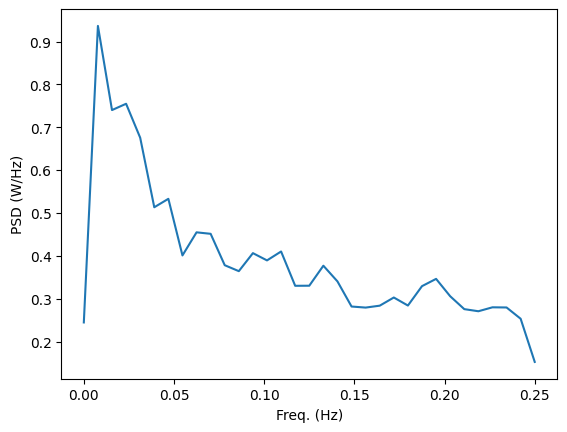

In [11]:
mu_pxx = np.mean(Pxx,axis = 1) # averaged across all voxels
mu_pxx.shape
plt.plot(freqs, mu_pxx.T)

plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')

#### 2) Plot average PSD of each frequency bin (selected ROIs)

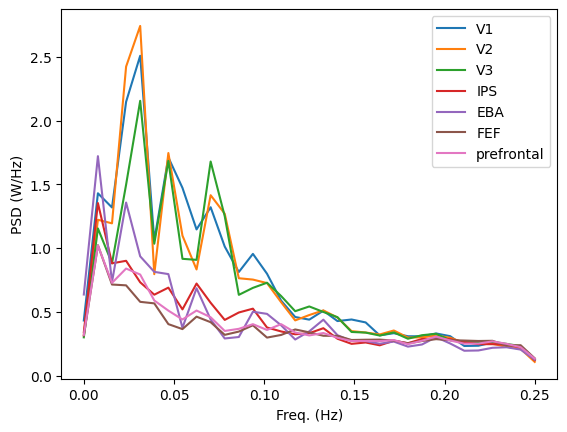

In [12]:
# plot PSD over frequency bins
for roi in roi_voxs:
    mu_roi_pxx = np.mean(Pxx[:,roi_voxs[roi]], axis=1)
    plt.plot(freqs, mu_roi_pxx.T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')
plt.legend()

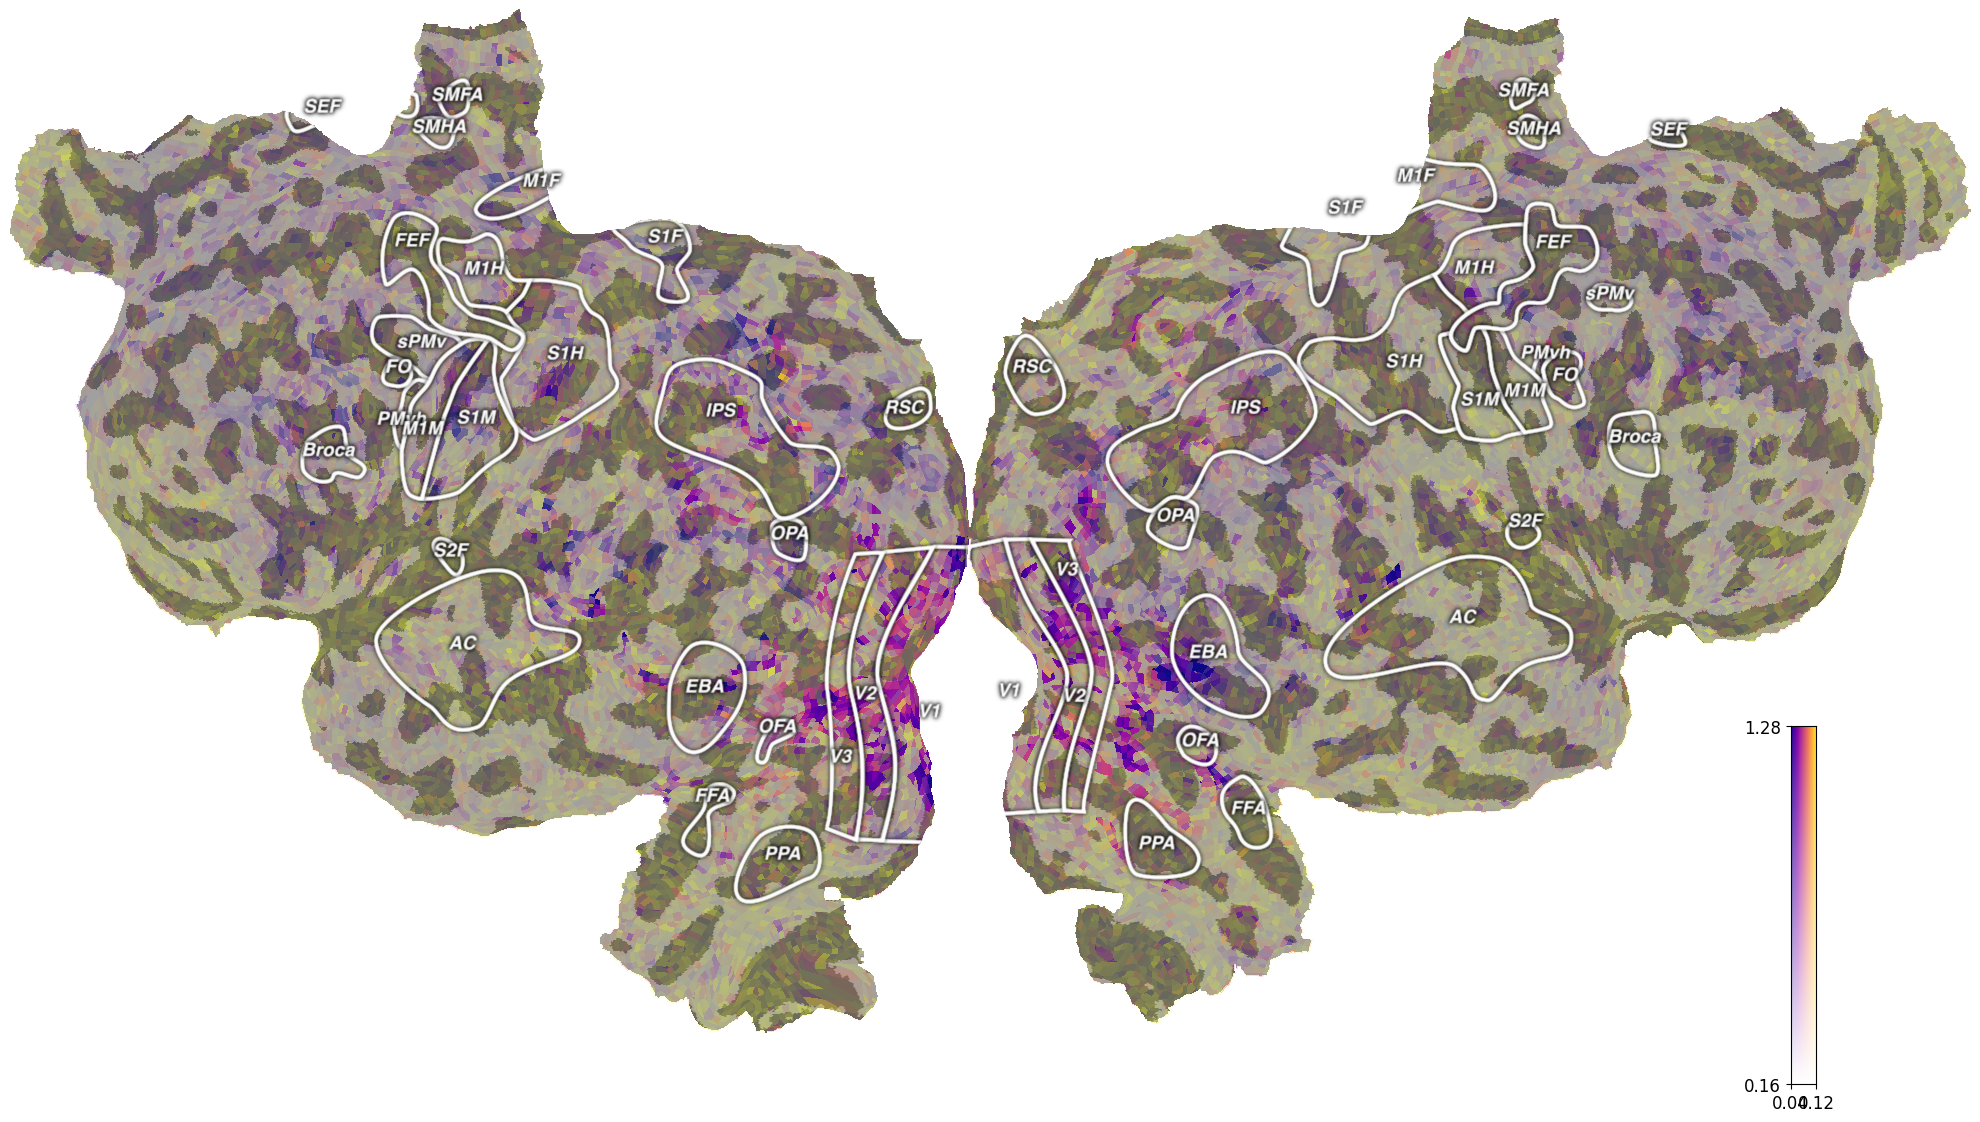

In [17]:
# Plot with pycortex

flatmap_kwargs = {'recache': False, 'pixelwise': True, 'sampler': 'nearest',
    'height': 1024, 'with_rois': True, #'with_labels': False, 
    'with_curvature': True, 'curvature_threshold': True, 'linewidth': 4,
    'nanmean': True}

weights_sum = np.sum(Pxx, axis=0)
valid_vox = weights_sum != 0 # get rid of 0s
vol_data = np.zeros(Pxx.shape[1])
vol_data[valid_vox] = np.average(np.broadcast_to(freqs[:, None], Pxx[:, valid_vox].shape), weights=Pxx[:, valid_vox], axis=0) # weighted average of frequency bins by power
# vol = cortex.Volume(vol_data, subject, xfmname=xfm, cmap='plasma')
# cortex.quickshow(vol);
vol2d = cortex.Volume2D(vol_data, Pxx.mean(0), subject, xfmname=xfm, cmap='plasma_alpha', vmin=0.04, vmax=0.12)
colorbar_location = (0.90, -0.05, 0.03, 0.35)
cortex.quickshow(vol2d, thick=1, colorbar_location = colorbar_location, **flatmap_kwargs);
# plt.savefig("psd_2d_centerofmass.pdf", format='pdf', bbox_inches='tight')

## 2. Compute coherence as a measure of SNR

In [18]:
from scipy.signal import welch

def compute_coherence_spectrum(data, fs, nfft=64):
    """Computes the coherency of the voxel's responses across repeats.
    [data] is assumed to be a 2D matrix: repeats x time.
    [Fs] should be the sampling rate of the data (i.e. 0.5 for 2-second TR),
    and NFFT is the number of FFT windows used in the power spectral density estimate.

    From Hsu, Borst, Theunissen 2004, Eq 5
    """
    noverlap = nfft // 2 
    params = dict(nperseg=nfft, fs=fs, noverlap=noverlap)
    
    # compute overall signal (mean across repeats)
    signal = np.mean(data, axis=0)  # (time, voxels)
    
    # compute overall noise (deviation from the mean signal)
    noise = data - signal  # (repeats, time, voxels)
    noise = noise.reshape(-1, data.shape[-1])  # flatten across repeats (repeats * time, voxels)
    
    # compute power spectral density for signal and noise
    freqs, spower = welch(signal, axis=0, **params)
    freqs, npower = welch(noise, axis=0, **params)
    
    # compute jackknifed noise (excluding each trial from the noise computation)
    num_repeats = data.shape[0]
    jnoises = np.zeros_like(data)
    
    for i in range(num_repeats):
        # exclude the i-th repeat and compute the mean of the rest
        idx = np.arange(num_repeats)
        jnoise = data[i,:,:] - np.mean(data[idx != i], axis=0)
        jnoises[i,:,:] = jnoise
    jnoises = jnoises.reshape(-1, data.shape[-1])  # flatten across repeats (repeats * time, voxels)
    
    # compute PSD for jackknifed noise
    freqs, jnpower = welch(jnoises, axis=0, **params)

    coherence_upper = spower/(npower + spower)
    coherence_lower = spower/(jnpower + spower)
    
    return freqs, spower, npower, jnpower, coherence_upper, coherence_lower

#### 1) Compute upper/lower bounds of coherence for all voxels

In [19]:
%%time
freqs, spower, npower, jnpower, coherence_upper, coherence_lower = compute_coherence_spectrum(response_trials, fs=0.5, nfft=64)

CPU times: user 2.32 s, sys: 3.99 s, total: 6.31 s
Wall time: 8.74 s


/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_82286/1551819756.py:39: RuntimeWarning: invalid value encountered in divide
  coherence_upper = spower/(npower + spower)
/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_82286/1551819756.py:40: RuntimeWarning: invalid value encountered in divide
  coherence_lower = spower/(jnpower + spower)


#### 2) Plot coherence spectrum (averaged across all voxels within each ROI) - uncorrected

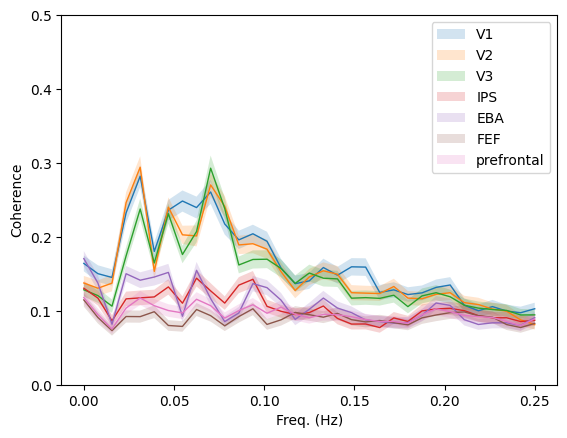

In [84]:
for roi in roi_voxs:
    ub_coherence = np.mean(coherence_upper[:,roi_voxs[roi]], axis=1)
    lb_coherence = np.mean(coherence_lower[:,roi_voxs[roi]], axis=1)
    plt.fill_between(freqs, lb_coherence, ub_coherence, alpha=0.2, label=roi)
    
    mean_coherence = (ub_coherence + lb_coherence) / 2
    plt.plot(freqs, mean_coherence, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.5)  
plt.legend()

#### 3) Plot coherence spectrum - permutation-based baseline correction

In [20]:
# breaking down and shuffling
nRep = response_trials.shape[0]
segment_size = 10  
n_segments = response_trials.shape[1] // segment_size  
shuffled_resps = np.zeros_like(response_trials)

for i in range(nRep):
    segments = np.array_split(response_trials[i, :n_segments * segment_size, :], indices_or_sections=n_segments, axis=0)
    last_segment = response_trials[i, n_segments * segment_size:, :]  
    np.random.shuffle(segments)
    if last_segment.size > 0:  # Only concatenate if the last segment is non-empty
        shuffled_vec = np.concatenate(segments + [last_segment], axis=0)
    else:
        shuffled_vec = np.concatenate(segments, axis=0)
    shuffled_resps[i,:,:] = shuffled_vec

In [21]:
freqs, spower_seg, npower_seg, jnpower_seg, coherence_upper_seg, coherence_lower_seg = compute_coherence_spectrum(shuffled_resps, fs=0.5, nfft=64)

/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_82286/1551819756.py:39: RuntimeWarning: invalid value encountered in divide
  coherence_upper = spower/(npower + spower)
/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_82286/1551819756.py:40: RuntimeWarning: invalid value encountered in divide
  coherence_lower = spower/(jnpower + spower)


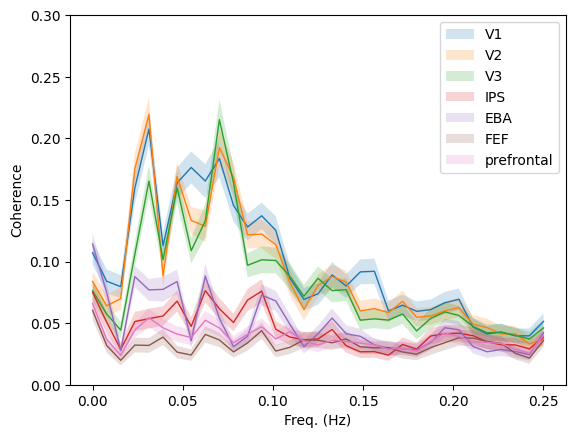

In [22]:
# Compute and plot coherence baseline, then subtract baseline and plot denoised coherence
baselines = np.array([
    np.mean((np.mean(coherence_upper_seg[:, roi_voxs[roi]], axis=1) + 
             np.mean(coherence_lower_seg[:, roi_voxs[roi]], axis=1)) / 2, axis=0)
    for roi in roi_voxs
])

mean_baseline = np.mean(baselines)
coherence_upper_denoise = np.clip(coherence_upper - mean_baseline, 0, 1)
coherence_lower_denoise = np.clip(coherence_lower - mean_baseline, 0, 1)

for roi in roi_voxs:
    ub_coherence_denoise = np.mean(coherence_upper_denoise[:, roi_voxs[roi]], axis=1)
    lb_coherence_denoise = np.mean(coherence_lower_denoise[:, roi_voxs[roi]], axis=1)
    mean_coherence_denoise = (ub_coherence_denoise + lb_coherence_denoise) / 2
    
    plt.fill_between(freqs, lb_coherence_denoise, ub_coherence_denoise, alpha=0.2, label=roi)
    plt.plot(freqs, mean_coherence_denoise, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.3)
plt.legend()

#### 5) Plot center of mass for each frequency spectrum (weighted by coherence) 

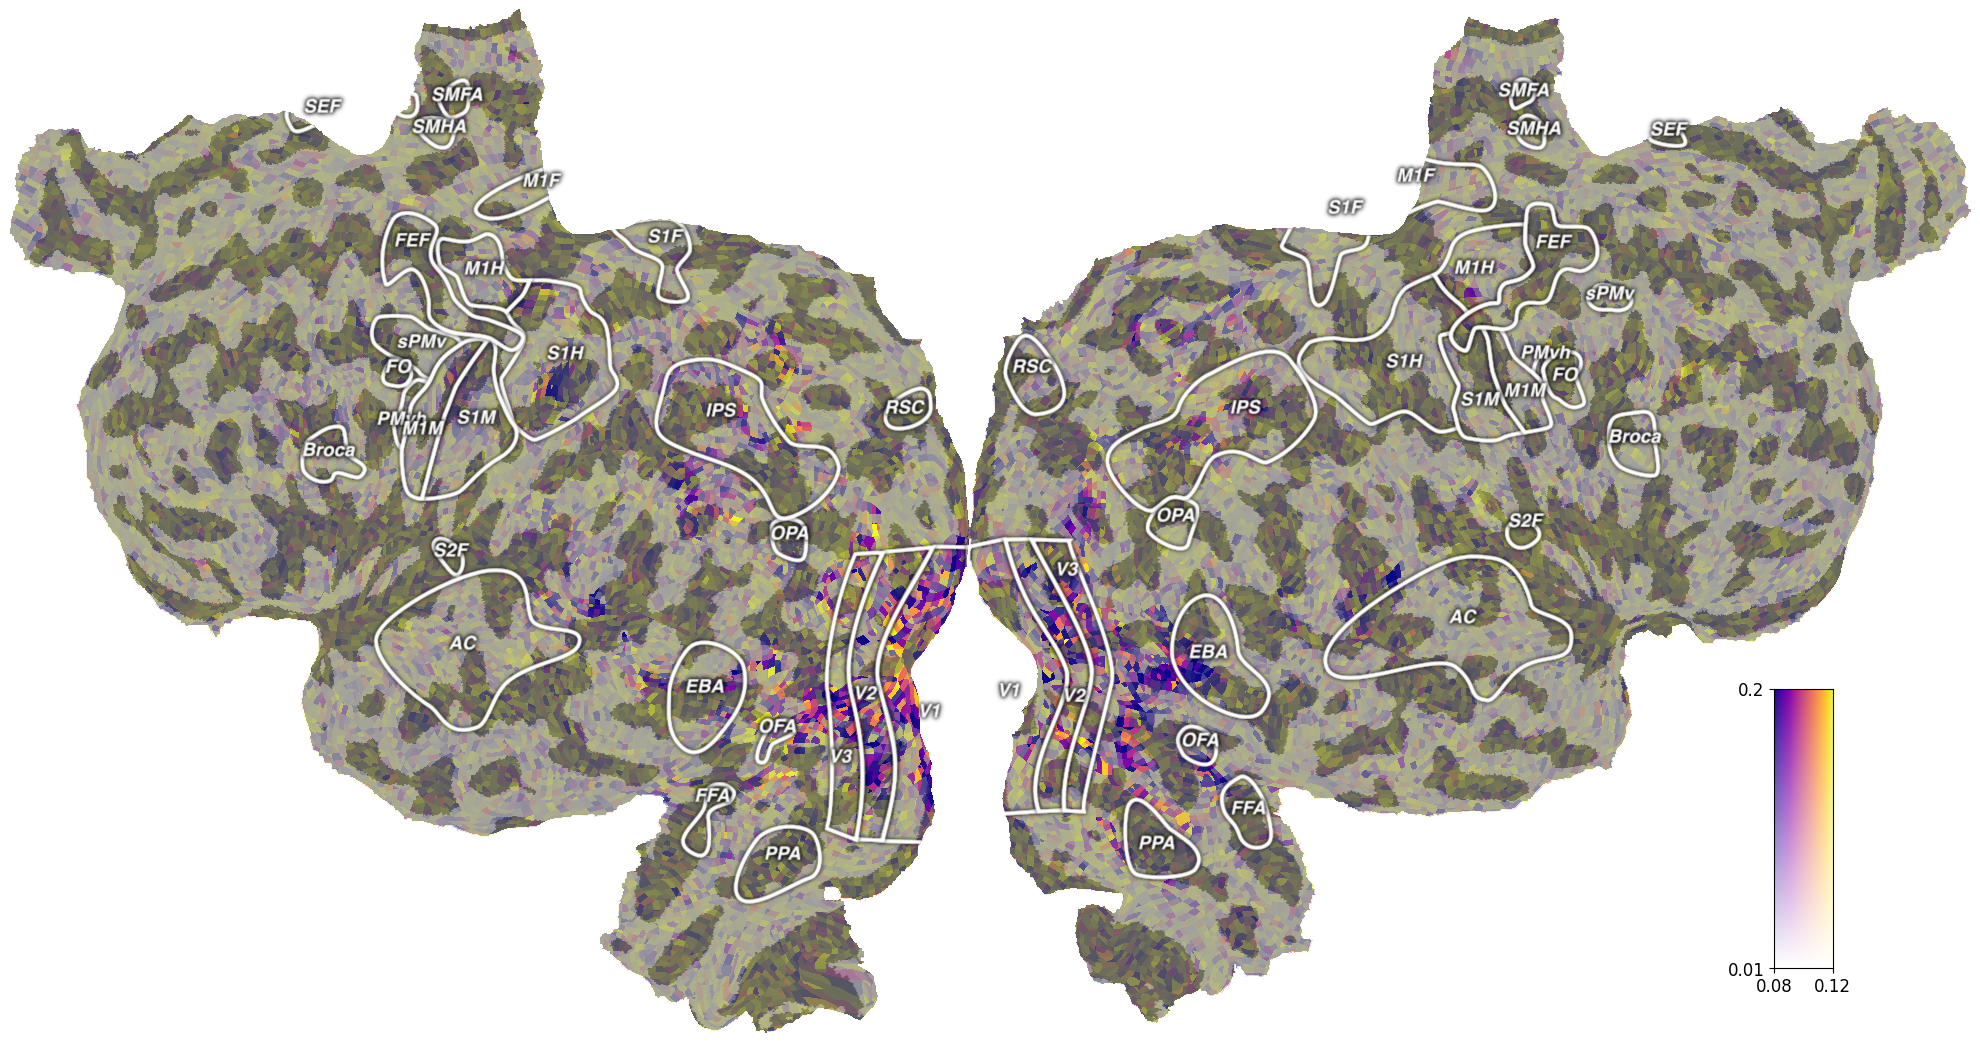

In [23]:
# Plot with pycortex
# get weighted average of frequency bins by coherence - find the center of mass of the coherence spectrum
vol_data = np.average(np.broadcast_to(freqs[:, None], coherence_upper_denoise.shape), weights= np.clip(coherence_upper_denoise,1e-10,1), axis=0)

vol2d = cortex.Volume2D(vol_data, coherence_upper_denoise.mean(0), subject, xfmname=xfm, cmap='plasma_alpha', vmin=0.08, vmax=0.12)

colorbar_location = (0.90, -0.05, 0.03, 0.5)
cortex.quickshow(vol2d, thick=1, colorbar_location = colorbar_location, **flatmap_kwargs);


In [36]:
from cortex.options import config
print(config.get('basic', 'filestore'))

/Users/jiamingxu/miniconda3/share/pycortex/db


In [37]:
!open /Users/jiamingxu/miniconda3/share/pycortex/db

### Fit AR(1) and AR(2) directly to average of 10 repeats

In [ ]:
def correct_bias(response_trials, nRuns, nT):
    # response_trials should have the shape (nRuns, timepoints)
    residual_var = []
    avg_resp = np.mean(response_trials,0)
    for t in range(nT):
        residuals_t = np.zeros(nRuns)
        for i in range(nRuns):
            residuals_t[i] = (response_trials[i,t] - avg_resp[t])**2 
        residuals_var_t = np.sum(residuals_t) / (nRuns - 1)
        residual_var.append(residuals_var_t)

    avg_residual_var = np.mean(residual_var)
    sigma_n_sq = avg_residual_var/nRuns*(1/nRuns+1)    
    
    return sigma_n_sq

In [16]:
zs = lambda v: (v-v.mean(0))/v.std(0)
#avg_reps = np.mean(response_trials,0)
#norm_avg_reps = zs(avg_reps)
demean_resp = norm_avg_reps - np.broadcast_to(np.mean(norm_avg_reps,0), norm_avg_reps.shape)

roi_ar1_coeff = {}
roi_ar1_coeff_corrected = {}
for roi in roi_voxs:
    roi_mean = np.mean(response_trials[:,:,roi_voxs[roi]], axis=2)
    roi_run_mean = np.mean(roi_mean, axis=0)
    roi_run_mean_norm = zs(roi_run_mean)
    ar1_model = sm.tsa.AutoReg(roi_run_mean_norm, lags = 1).fit()
    roi_ar1_coeff[roi] = ar1_model.params[1]
    # correct for bias
    sigma_n_sq = correct_bias(roi_mean, response_trials.shape[0], response_trials.shape[1])
    corrected_ar1_coeff[roi] = roi_ar1_coeff[roi] + (roi_ar1_coeff[roi] * sigma_n_sq)

print(corrected_ar1_coeff)
    
   